In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display


%matplotlib inline

In [2]:
x_train = pd.read_csv('data/s2e/audio_train.csv')
x_test = pd.read_csv('data/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(54022, 10)


In [3]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(54022, 10) (13506, 10)
{3: 36195, 4: 11501, 2: 2505, 5: 1518, 1: 1387, 0: 916}


In [4]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    print(classification_report(y_test, pred, target_names=emo_keys))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.933
Test Set F-score =  0.597
Test Set Precision =  0.621
Test Set Recall =  0.595
              precision    recall  f1-score   support

         ang       0.47      0.34      0.39       241
         hap       0.36      0.19      0.25       360
         sad       0.48      0.72      0.58       633
         fea       1.00      1.00      1.00      8972
         sur       1.00      1.00      1.00      2898
         neu       0.42      0.32      0.36       402

    accuracy                           0.93     13506
   macro avg       0.62      0.59      0.60     13506
weighted avg       0.93      0.93      0.93     13506

Confusion matrix, without normalization
[[  81   46   82    1    3   28]
 [  31   68  189    1    3   68]
 [  34   51  456    1    4   87]
 [   0    0    0 8972    0    0]
 [   0    0    0    0 2898    0]
 [  26   24  217    2    3  130]]


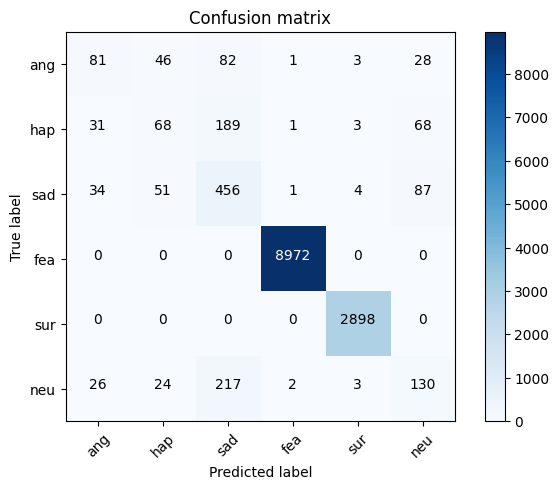

In [5]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/s2e/RF.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

[15:43:37] WARNING: ../src/learner.cc:767: 
Parameters: { "sub_sample" } are not used.

Test Set Accuracy =  0.927
Test Set F-score =  0.587
Test Set Precision =  0.615
Test Set Recall =  0.574
              precision    recall  f1-score   support

         ang       0.45      0.35      0.39       241
         hap       0.41      0.22      0.29       360
         sad       0.49      0.57      0.52       633
         fea       0.99      1.00      1.00      8972
         sur       0.96      1.00      0.98      2898
         neu       0.40      0.31      0.35       402

    accuracy                           0.93     13506
   macro avg       0.62      0.57      0.59     13506
weighted avg       0.92      0.93      0.92     13506

Confusion matrix, without normalization
[[  85   36   64   14   19   23]
 [  34   79  137   17   30   63]
 [  45   55  359   30   45   99]
 [   0    0    0 8972    0    0]
 [   0    0    0    0 2898    0]
 [  27   23  176   26   27  123]]


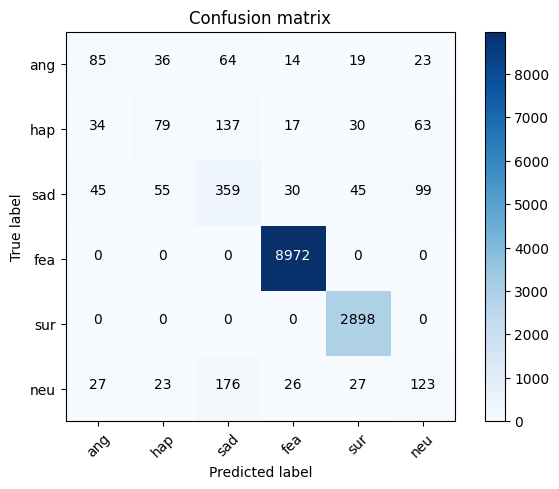

In [6]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob',
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/s2e/XGB.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

Iteration 1, loss = 0.97348348
Iteration 2, loss = 0.89347219
Iteration 3, loss = 0.83401218
Iteration 4, loss = 0.79871967
Iteration 5, loss = 0.77578001
Iteration 6, loss = 0.76330617
Iteration 7, loss = 0.74667039
Iteration 8, loss = 0.73585990
Iteration 9, loss = 0.72938105
Iteration 10, loss = 0.72089839
Iteration 11, loss = 0.71431393
Iteration 12, loss = 0.70876524
Iteration 13, loss = 0.70382124
Iteration 14, loss = 0.69939671
Iteration 15, loss = 0.69301723
Iteration 16, loss = 0.69110836
Iteration 17, loss = 0.68401201
Iteration 18, loss = 0.67880534
Iteration 19, loss = 0.67256848
Iteration 20, loss = 0.67081692
Iteration 21, loss = 0.66048164
Iteration 22, loss = 0.65760445
Iteration 23, loss = 0.65416835
Iteration 24, loss = 0.64400574
Iteration 25, loss = 0.64025393
Iteration 26, loss = 0.63381722
Iteration 27, loss = 0.62612995
Iteration 28, loss = 0.62594760
Iteration 29, loss = 0.61461219
Iteration 30, loss = 0.61500756
Iteration 31, loss = 0.61182815
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Test Set Accuracy =  0.846
Test Set F-score =  0.397
Test Set Precision =  0.571
Test Set Recall =  0.368
              precision    recall  f1-score   support

         ang       0.67      0.15      0.24       241
         hap       0.31      0.12      0.17       360
         sad       0.38      0.11      0.17       633
         fea       0.89      1.00      0.94      8972
         sur       0.77      0.79      0.78      2898
         neu       0.42      0.04      0.08       402

    accuracy                           0.85     13506
   macro avg       0.57      0.37      0.40     13506
weighted avg       0.80      0.85      0.81     13506

Confusion matrix, without normalization
[[  36   32   17   62   93    1]
 [   8   42   23  128  145   14]
 [   7   28   68  255  265   10]
 [   0    0    0 8972    0    0]
 [   0   23   30  552 2293    0]
 [   3   12   41  146  182   18]]


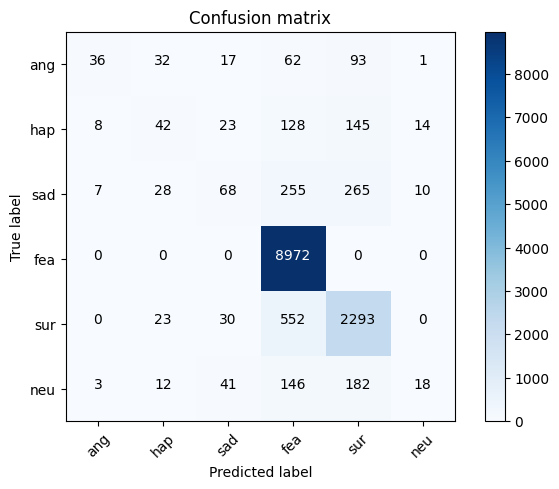

In [16]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=True, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/s2e/MLP.pkl', 'wb') as f:
    pickle.dump(mlp_classifier, f)

Test Set Accuracy =  0.672
Test Set F-score =  0.153
Test Set Precision =  0.333
Test Set Recall =  0.176
              precision    recall  f1-score   support

         ang       0.75      0.02      0.05       241
         hap       0.00      0.00      0.00       360
         sad       0.00      0.00      0.00       633
         fea       0.67      1.00      0.80      8972
         sur       0.58      0.03      0.06      2898
         neu       0.00      0.00      0.00       402

    accuracy                           0.67     13506
   macro avg       0.33      0.18      0.15     13506
weighted avg       0.58      0.67      0.55     13506

Confusion matrix, without normalization
[[   6    3    0  189   43    0]
 [   2    0    0  346   12    0]
 [   0    0    0  625    8    0]
 [   0    0    0 8972    0    0]
 [   0    0    0 2801   97    0]
 [   0    0    0  394    8    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

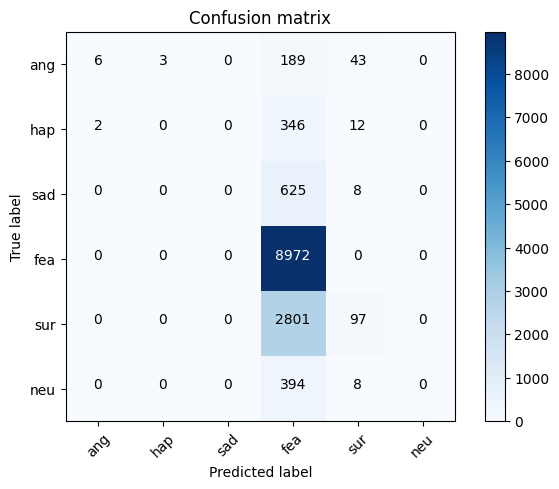

In [10]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
print(classification_report(y_test, pred, target_names=emo_keys))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())
(y_test, pred_probs)

with open('pred_probas/svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

with open('trained_models/s2e/SVC.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.666
Test Set F-score =  0.138
Test Set Precision =  0.438
Test Set Recall =  0.169
              precision    recall  f1-score   support

         ang       1.00      0.00      0.01       241
         hap       0.00      0.00      0.00       360
         sad       0.00      0.00      0.00       633
         fea       0.67      1.00      0.80      8972
         sur       0.96      0.01      0.02      2898
         neu       0.00      0.00      0.00       402

    accuracy                           0.67     13506
   macro avg       0.44      0.17      0.14     13506
weighted avg       0.67      0.67      0.53     13506

Confusion matrix, without normalization
[[   1    0    0  239    1    0]
 [   0    0    0  360    0    0]
 [   0    0    0  633    0    0]
 [   0    0    0 8972    0    0]
 [   0    0    0 2872   26    0]
 [   0    0    0  402    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

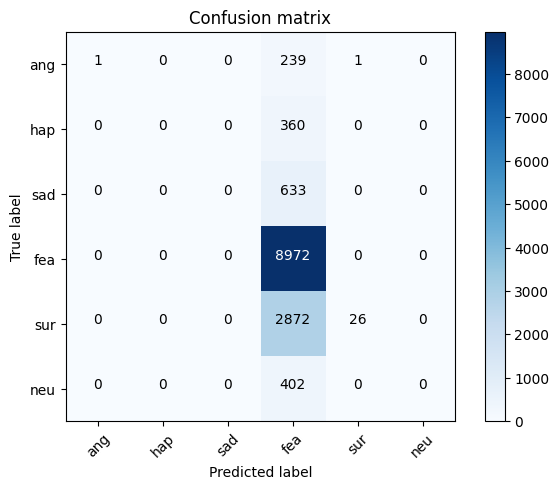

In [11]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/s2e/MNB.pkl', 'wb') as f:
    pickle.dump(mnb_classifier, f)

Test Set Accuracy =  0.671
Test Set F-score =  0.157
Test Set Precision =  0.325
Test Set Recall =  0.179
              precision    recall  f1-score   support

         ang       0.73      0.05      0.09       241
         hap       0.00      0.00      0.00       360
         sad       0.00      0.00      0.00       633
         fea       0.67      1.00      0.80      8972
         sur       0.55      0.03      0.05      2898
         neu       0.00      0.00      0.00       402

    accuracy                           0.67     13506
   macro avg       0.33      0.18      0.16     13506
weighted avg       0.58      0.67      0.55     13506

Confusion matrix, without normalization
[[  11    0    0  190   40    0]
 [   2    0    0  348   10    0]
 [   1    0    0  627    5    0]
 [   0    0    0 8972    0    0]
 [   0    0    0 2823   75    0]
 [   1    0    0  394    7    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

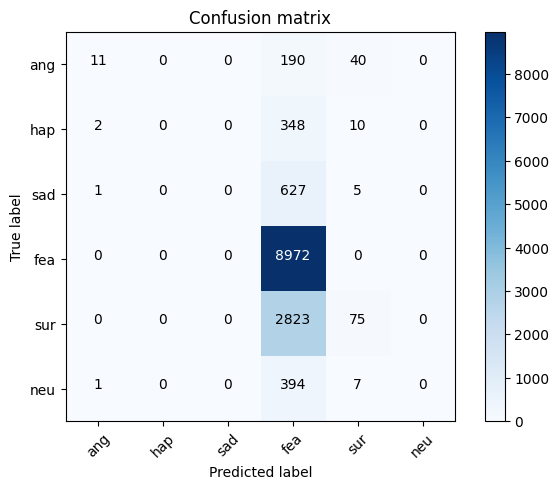

In [12]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/s2e/LR.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

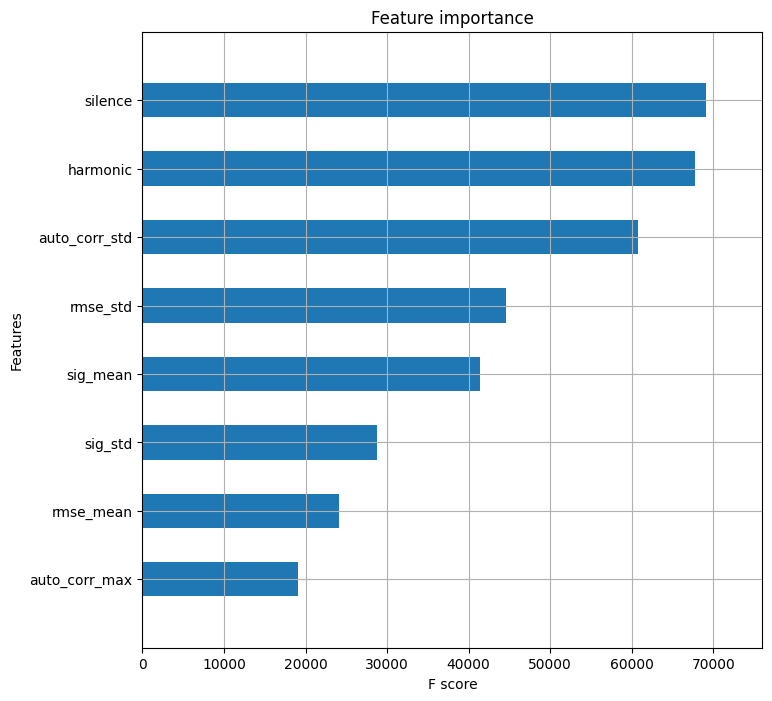

In [13]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

In [14]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.12094053, 0.0637164 , 0.19258994, 0.14631358, 0.09002527,
       0.106658  , 0.18565722, 0.09409901], dtype=float32)

In [23]:
top_n = [3, 5, 6, 7, 8]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)

    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob',
                                              n_estimators=1200, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 3 features:
[16:22:55] WARNING: ../src/learner.cc:767: 
Parameters: { "sub_sample" } are not used.

Test Set Accuracy =  0.919
Test Set F-score =  0.554
Test Set Precision =  0.600
Test Set Recall =  0.533
              precision    recall  f1-score   support

         ang       0.53      0.32      0.40       241
         hap       0.33      0.19      0.24       360
         sad       0.49      0.51      0.50       633
         fea       0.98      1.00      0.99      8972
         sur       0.93      1.00      0.96      2898
         neu       0.33      0.18      0.23       402

    accuracy                           0.92     13506
   macro avg       0.60      0.53      0.55     13506
weighted avg       0.90      0.92      0.91     13506

Stats for top 5 features:
[16:26:09] WARNING: ../src/learner.cc:767: 
Parameters: { "sub_sample" } are not used.

Test Set Accuracy =  0.922
Test Set F-score =  0.563
Test Set Precision =  0.596
Test Set Recall =  0.547
              pre

Test Set Accuracy =  0.922
Test Set F-score =  0.577
Test Set Precision =  0.642
Test Set Recall =  0.548
              precision    recall  f1-score   support

         ang       0.55      0.32      0.40       241
         hap       0.42      0.19      0.26       360
         sad       0.52      0.55      0.53       633
         fea       0.97      1.00      0.99      8972
         sur       0.94      1.00      0.97      2898
         neu       0.46      0.23      0.31       402

    accuracy                           0.92     13506
   macro avg       0.64      0.55      0.58     13506
weighted avg       0.91      0.92      0.91     13506

Confusion matrix, without normalization
[[  77   37   55   31   27   14]
 [  24   69  124   60   39   44]
 [  22   41  347  108   64   51]
 [   0    0    0 8972    0    0]
 [   0    0    0    0 2898    0]
 [  18   17  147   74   53   93]]


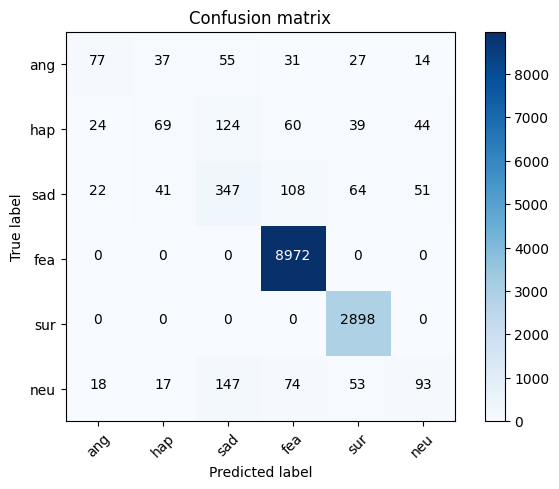

In [17]:
# Load predicted probabilities
# Load predicted probabilities
with open('pred_probas/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)

with open('pred_probas/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)

with open('pred_probas/mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)

with open('pred_probas/mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)

with open('pred_probas/lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

with open('pred_probas/lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)